In [26]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta
import sys
from datetime import datetime
import multiprocessing as mp

M0 = 1480 #mT
shape = [[5*25.4/16, 25.4/8], [5*25.4/16, 2*25.4/8]] #radius and height

x0 = np.array([0,0,10, 0,0,1])

In [27]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, options={'maxiter':100000}, *args
    ) 
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res.x 

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Time Passed (s)')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Time Passed (s)')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

# Function to convert HHMMSS to seconds
def time_to_seconds(time_str):
    hours = int(time_str[:2])
    minutes = int(time_str[2:4])
    seconds = int(time_str[4:6])
    return hours * 3600 + minutes * 60 + seconds

def time_to_secondsdf(time_value):
    return time_value.hour * 3600 + time_value.minute * 60 + time_value.second + time_value.microsecond / 1e6

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path (without the extension)
    filename = os.path.basename(file_path).replace('.npz', '')
    
    # Split the filename into date, time, and millisecond parts
    date_part = filename.split('-')[0]  # Extracting the 'YYYYMMDD' partshapeimpo
    time_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    millisecond_part = filename.split('-')[2]  # Extracting the millisecond part
    
    # Combine date, time, and milliseconds into a full timestamp string
    full_datetime_str = f"{date_part} {time_part}.{millisecond_part}"
    
    # Create a datetime object
    full_datetime = datetime.strptime(full_datetime_str, "%Y%m%d %H%M%S.%f")
    
    return full_datetime

def importfitting(folder, shape):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    timestamps = []

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        timestamps.append(extract_timestamp(file_list[x]))

        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return pos, mags, locpred, anglepred, Bstdev, timestamps

def importdata(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    B = [np.array(pos)]
    timestamps = []

    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        mags = np.mean(mags, axis=0)
        
        B = np.append(B, [mags], axis=0)
        timestamps.append(extract_timestamp(file_list[x]))  
    B = np.delete(B, 0, axis=0)

    return B, timestamps

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

def sensorplots(B, timestamps,sensor):
    mag = [np.array([0, 0, 0])]
    for x in range(len(B)):
        mag = np.append(mag, [B[x][sensor]], axis=0)
    mag = np.delete(mag, 0, axis=0)

    measuredbx = go.Scatter(x=timestamps, y=mag[:,0], mode='markers')
    layoutbx = go.Layout(title='b_x over time, sensor ' + str(sensor))
    figbx = go.Figure(data=[measuredbx], layout=layoutbx)
    figbx.update_yaxes(scaleanchor='y')
    figbx.update_layout(
        xaxis_title="Time",
        yaxis_title="b_x [mT]"
    )
    figbx.show()

    measuredby = go.Scatter(x=timestamps, y=mag[:,1], mode='markers')
    layoutby = go.Layout(title='b_y over time sensor ' + str(sensor))
    figby = go.Figure(data=[measuredby], layout=layoutby)
    figby.update_yaxes(scaleanchor='y')
    figby.update_layout(
        xaxis_title="Time",
        yaxis_title="b_y [mT]"
    )
    figby.show()

    measuredbz = go.Scatter(x=timestamps, y=mag[:,2], mode='markers')
    layoutbz = go.Layout(title='b_z over time sensor ' + str(sensor))
    figbz = go.Figure(data=[measuredbz], layout=layoutbz)
    figbz.update_yaxes(scaleanchor='y')
    figbz.update_layout(
        xaxis_title="Time",
        yaxis_title="b_z [mT]"
    )
    figbz.show()

In [28]:
folder = os.path.join('..', './20251107_server1')
B, timestamps = importdata(folder)

In [29]:
sensorplots(B, timestamps, 6)

import functions from MagneticSensorTracking
graph bx, by, bz for all 16 sensors
try averaging the sensors logs
try restarting pi to see if time error is from restarts
fix the mount

In [30]:
pos, mags, locpred, anglepred, Bstdev, timestamps = importfitting(folder, shape[0])
np.append(locpred, anglepred, axis=1)
#print(timeelapsed)
print(len(locpred))

rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

1190


In [31]:
#folder2 = os.path.join('..', './')
#B2, timestamps2 = importdata(folder2)

In [32]:
#sensorplots(B2, timestamps2, 6)

In [33]:
'''pos2, mags2, locpred2, anglepred2, Bstdev2, timestamps2 = importfitting(folder2, shape[1])
np.append(locpred2, anglepred2, axis=1)
#print(timeelapsed)
print(len(locpred2))

rel_loc_predx2 = [x - locpred2[0,0] for x in locpred2[:,0]]
rel_loc_predy2 = [x - locpred2[0,1] for x in locpred2[:,1]]
rel_loc_predz2 = [x - locpred2[0,2] for x in locpred2[:,2]]



dispx2 = np.array(rel_loc_predx2)
dispy2 = np.array(rel_loc_predy2)
dispz2 = np.array(rel_loc_predz2)
disp2 = np.sqrt(dispx2**2+dispy2**2+dispz2**2)'''

'pos2, mags2, locpred2, anglepred2, Bstdev2, timestamps2 = importfitting(folder2, shape[1])\nnp.append(locpred2, anglepred2, axis=1)\n#print(timeelapsed)\nprint(len(locpred2))\n\nrel_loc_predx2 = [x - locpred2[0,0] for x in locpred2[:,0]]\nrel_loc_predy2 = [x - locpred2[0,1] for x in locpred2[:,1]]\nrel_loc_predz2 = [x - locpred2[0,2] for x in locpred2[:,2]]\n\n\n\ndispx2 = np.array(rel_loc_predx2)\ndispy2 = np.array(rel_loc_predy2)\ndispz2 = np.array(rel_loc_predz2)\ndisp2 = np.sqrt(dispx2**2+dispy2**2+dispz2**2)'

In [34]:
folder3 = os.path.join('..', './20251107_server3')
B3, timestamps3 = importdata(folder3)

In [35]:
sensorplots(B3, timestamps3, 6)

In [36]:
pos3, mags3, locpred3, anglepred3, Bstdev3, timestamps3 = importfitting(folder3, shape[0])
np.append(locpred3, anglepred3, axis=1)
#print(timeelapsed)
print(len(locpred3))

rel_loc_predx3 = [x - locpred3[0,0] for x in locpred3[:,0]]
rel_loc_predy3 = [x - locpred3[0,1] for x in locpred3[:,1]]
rel_loc_predz3 = [x - locpred3[0,2] for x in locpred3[:,2]]



dispx3 = np.array(rel_loc_predx3)
dispy3 = np.array(rel_loc_predy3)
dispz3 = np.array(rel_loc_predz3)
disp3 = np.sqrt(dispx3**2+dispy3**2+dispz3**2)

1327


In [37]:
# Specify the Excel file name (replace with your actual file name)
file = 'Shift_data_20251107.txt'

# Create the full file path
file_path = os.path.join('..', file)

# Read the Excel file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter=',', na_values="        NaN")

df.dropna(inplace=True)
df[['X', 'Y', 'Z', 'Displacement [mm]']] = df[['X', 'Y', 'Z', 'Displacement [mm]']].apply(pd.to_numeric,errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%S.%f')
df['datetime'] = df.loc[0:,'Time'].dt.time


print(df)
hdmm_time = df['Time']
hdmm_disp = df.loc[0:,'Displacement [mm]']
hdmm_x = df.loc[0:, 'X']
hdmm_y = df.loc[0:, 'Y']
hdmm_z = df.loc[0:, 'Z']
print(hdmm_time)

                       Time     X     Y     Z  Displacement [mm]  \
4   2025-11-07 15:23:04.546  0.00  0.00  0.00               0.00   
5   2025-11-07 15:23:05.061 -0.01  0.01 -0.04               0.04   
6   2025-11-07 15:23:05.578 -0.02  0.00 -0.02               0.03   
7   2025-11-07 15:23:06.097  0.00 -0.02 -0.02               0.03   
8   2025-11-07 15:23:06.610  0.00  0.00 -0.04               0.04   
..                      ...   ...   ...   ...                ...   
947 2025-11-07 15:31:13.482  0.01  0.00 -0.04               0.04   
948 2025-11-07 15:31:13.999 -0.00  0.01  0.02               0.02   
949 2025-11-07 15:31:14.511  0.01 -0.00 -0.02               0.02   
950 2025-11-07 15:31:15.028  0.00 -0.00 -0.02               0.02   
951 2025-11-07 15:31:15.545  0.01  0.00 -0.04               0.04   

            datetime  
4    15:23:04.546000  
5    15:23:05.061000  
6    15:23:05.578000  
7    15:23:06.097000  
8    15:23:06.610000  
..               ...  
947  15:31:13.482000  

In [38]:
def align_timestamps(data1, timestamps1, data2, timestamps2):
    """
    Returns (time_diff, adjusted_timestamps) where time_diff is a pd.Timedelta
    applied to timestamps2 so data2 aligns to data1 in time.
    """
    # ---- prep
    t1 = pd.to_datetime(timestamps1)
    t2 = pd.to_datetime(timestamps2)

    # make both naive (avoid tz mismatch) and sorted/unique
    if getattr(t1, 'tz', None) is not None: t1 = t1.tz_convert(None)
    if getattr(t2, 'tz', None) is not None: t2 = t2.tz_convert(None)
    # (if already naive, the above is a no-op)

    d1 = np.asarray(data1, dtype=float)
    d2 = np.asarray(data2, dtype=float)

    # Drop NaNs and enforce 1:1 time/value pairs
    s1 = pd.Series(d1, index=t1).sort_index()
    s2 = pd.Series(d2, index=t2).sort_index()
    s1 = s1[~s1.index.duplicated(keep="first")].dropna()
    s2 = s2[~s2.index.duplicated(keep="first")].dropna()

    # If either is too short, fall back to max-peak alignment
    if len(s1) < 3 or len(s2) < 3:
        max_index1 = int(np.nanargmax(s1.values))
        max_index2 = int(np.nanargmax(s2.values))
        time_diff = s1.index[max_index1] - s2.index[max_index2]
        return time_diff, (pd.to_datetime(timestamps2) + time_diff)

    # Determine overlap window
    start = max(s1.index[0], s2.index[0])
    end   = min(s1.index[-1], s2.index[-1])
    if start >= end:
        # No overlap: use peak align as a safe fallback
        max_index1 = int(np.nanargmax(s1.values))
        max_index2 = int(np.nanargmax(s2.values))
        time_diff = s1.index[max_index1] - s2.index[max_index2]
        return time_diff, (pd.to_datetime(timestamps2) + time_diff)

    s1 = s1.loc[start:end]
    s2 = s2.loc[start:end]

    # Infer a common resample step from median spacing (default 100 ms)
    def infer_step(idx):
        if len(idx) < 2: return pd.Timedelta(milliseconds=100)
        diffs = np.diff(idx.asi8)  # ns
        med = np.median(diffs)
        # guard against zeros/outliers
        if med <= 0: return pd.Timedelta(milliseconds=100)
        return pd.to_timedelta(int(med), unit='ns')

    step = min(infer_step(s1.index), infer_step(s2.index))
    # clamp to something reasonable (10 ms .. 1 s)
    step = max(min(step, pd.Timedelta(seconds=1)), pd.Timedelta(milliseconds=10))

    # Resample to common grid & interpolate
    new_index = pd.date_range(start=start, end=end, freq=step)
    x = s1.reindex(new_index).interpolate()
    y = s2.reindex(new_index).interpolate()

    # Normalize (remove means) and cross-correlate
    xn = (x - x.mean()).to_numpy()
    yn = (y - y.mean()).to_numpy()
    if xn.std() == 0 or yn.std() == 0:
        # Degenerate; fall back to peak align
        max_index1 = int(np.nanargmax(s1.values))
        max_index2 = int(np.nanargmax(s2.values))
        time_diff = s1.index[max_index1] - s2.index[max_index2]
        return time_diff, (pd.to_datetime(timestamps2) + time_diff)

    lags = np.arange(-len(xn) + 1, len(xn))
    xc = np.correlate(xn, yn, mode='full')
    best_lag = int(lags[np.argmax(xc)])  # samples
    time_diff = best_lag * step          # pd.Timedelta

    # Apply shift to the original (unmodified) timestamps2 you pass in
    adjusted_timestamps = pd.to_datetime(timestamps2) + time_diff
    return time_diff, adjusted_timestamps


tdiff, hdmm_timecorr = align_timestamps(disp3, timestamps3, hdmm_disp, hdmm_time)
display(hdmm_timecorr)
display(tdiff)

4     2025-09-16 22:34:59.172023
5     2025-09-16 22:34:59.687023
6     2025-09-16 22:35:00.204023
7     2025-09-16 22:35:00.723023
8     2025-09-16 22:35:01.236023
                 ...            
947   2025-09-16 22:43:08.108023
948   2025-09-16 22:43:08.625023
949   2025-09-16 22:43:09.137023
950   2025-09-16 22:43:09.654023
951   2025-09-16 22:43:10.171023
Name: Time, Length: 948, dtype: datetime64[ns]

Timedelta('-52 days +07:11:54.626023')

In [39]:
print(timestamps[0])
print(timestamps[-1])
print('-----------------------')
#print(timestamps2[0])
#print(timestamps2[-1])
print('-----------------------')
print(timestamps3[0])
print(timestamps3[-1])
print('-----------------------')

2025-09-16 22:30:03.402339
2025-09-16 22:41:20.452858
-----------------------
-----------------------
2025-09-16 22:28:40.386527
2025-09-16 22:41:18.280776
-----------------------


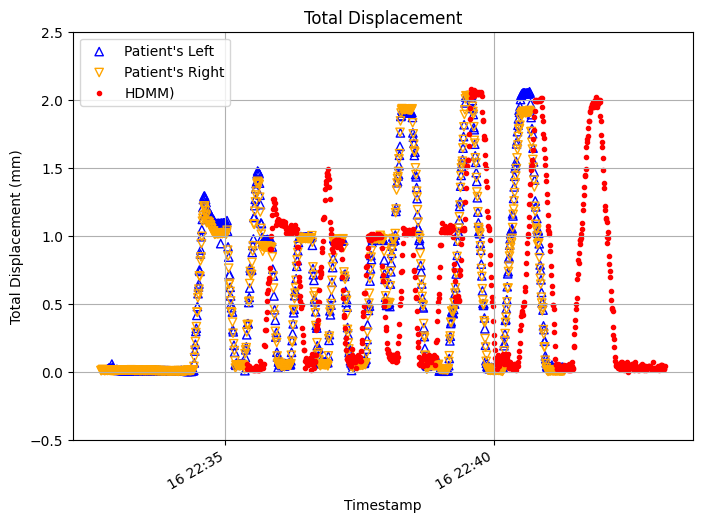

In [44]:

offset_seconds = 0.0       

hdmm_timecorr = pd.to_datetime(hdmm_timecorr)

# apply the shift
hdmm_timecorr_shifted = hdmm_timecorr + pd.to_timedelta(offset_seconds, unit='s')

# plot with the shifted timestamps
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-900:],  disp[-900:],  label="Patient's Left",  marker='^', edgecolors='blue',  facecolors='none')
plt.scatter(timestamps3[-900:], disp3[-900:], label="Patient's Right", marker='v', edgecolors='orange', facecolors='none')
plt.scatter(hdmm_timecorr_shifted[-900:], hdmm_disp[-900:], label=f'HDMM)', marker='.', color='red')
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp'); plt.ylabel('Total Displacement (mm)')
plt.ylim(-0.5, 2.5); plt.title('Total Displacement'); plt.legend(); plt.grid(True)
plt.show()


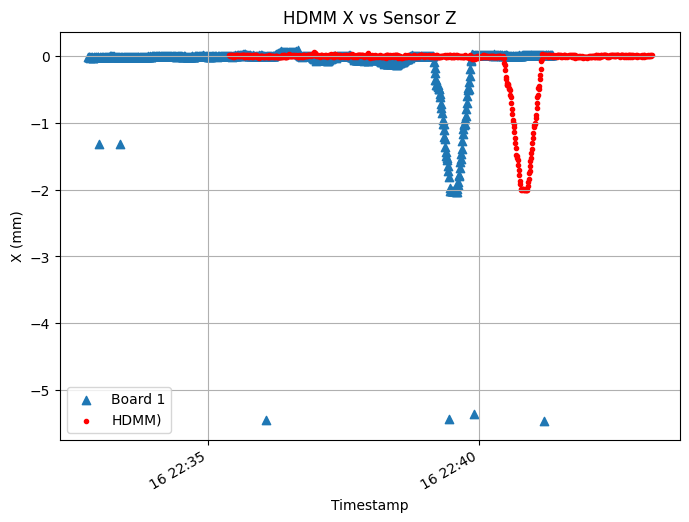

In [41]:

offset_s = 0.0  # tweak as needed

hdmm_timecorr_shift = pd.to_datetime(hdmm_timecorr) + pd.to_timedelta(offset_s, unit='s')

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-900:], rel_loc_predz[-900:], label='Board 1', marker='^')
# plt.scatter(timestamps2[-100:], rel_loc_predz2[-100:], label='Board 2', marker='v')
plt.scatter(hdmm_timecorr_shift[-900:], hdmm_x[-900:], label=f'HDMM)', marker='.', color='red')
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp'); plt.ylabel('X (mm)')
plt.title('HDMM X vs Sensor Z')
plt.grid(True); plt.legend(); plt.show()

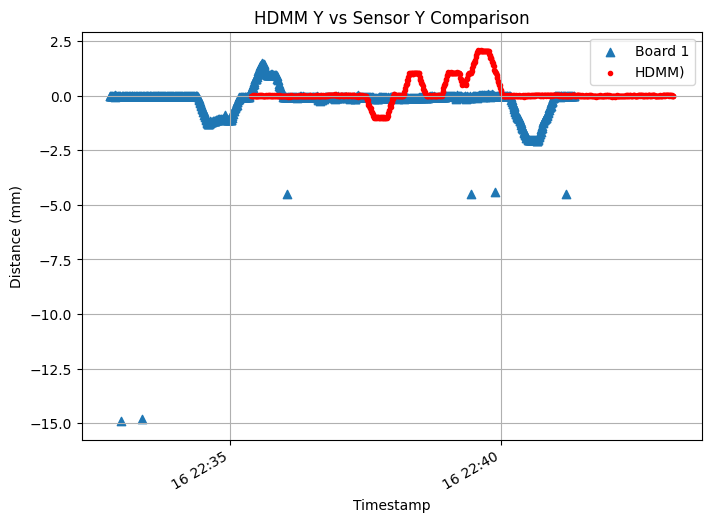

In [42]:
# manual x-shift for HDMM (positive = right, negative = left)
offset_s = 0.0
hdmm_timecorr_shift = pd.to_datetime(hdmm_timecorr) + pd.to_timedelta(offset_s, 's')

plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-900:], -np.array(rel_loc_predy[-900:]), label='Board 1', marker='^')
# plt.scatter(timestamps2[-900:], -np.array(rel_loc_predy2[-900:]), label='Board 2', marker='v')
plt.scatter(hdmm_timecorr_shift[-900:], hdmm_y[-900:],
            label=f'HDMM)', marker='.', color='red')
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp'); plt.ylabel('Distance (mm)')
plt.title('HDMM Y vs Sensor Y Comparison')
plt.grid(True); plt.legend(); plt.show()

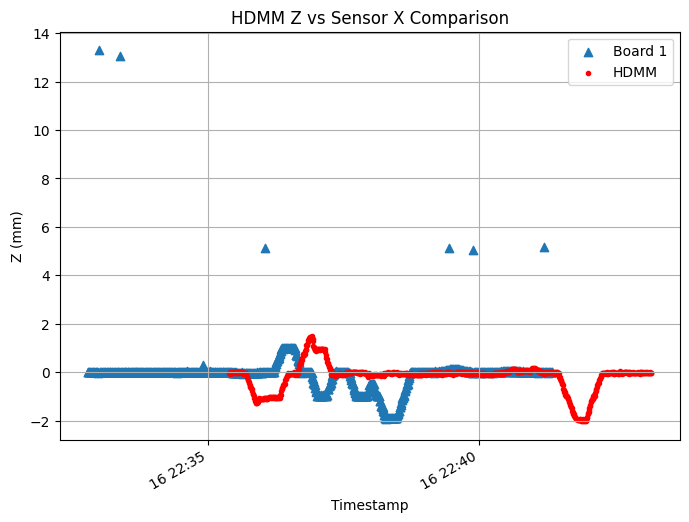

In [43]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps[-900:], rel_loc_predx[-900:], label='Board 1', marker='^')
#plt.scatter(timestamps2[-900:], rel_loc_predx2[-900:], label='Board 2', marker='v')
plt.scatter(hdmm_timecorr[-900:], hdmm_z[-900:], label='HDMM', marker='.', color='red')
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
plt.xlabel('Timestamp')
plt.ylabel('Z (mm)')
plt.title('HDMM Z vs Sensor X Comparison')
plt.grid(True)
plt.legend()
plt.show()

Try multiprocessing? simultaneous multi sensor data?
Finish 3d printing new top head mount, prototype side head mount
Fix time correction function


4/16/2025
Fix multiprocessing, make a mlx fitting package

fix top head mount + top magnet position

followup on CMRR reflow + pcb manufacturing

qwiic cables/hardware at microcenter